# Tutorial: Train SimSiam on Roboflow Pallets dataset

In [1]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision

from lightly.data import LightlyDataset
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimCLRTransform, utils

In [2]:
num_workers = 8
batch_size = 12
seed = 1
epochs = 50
input_size = 256

# dimension of the embeddings
num_ftrs = 512
# dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512
# the prediction head uses a bottleneck architecture
pred_hidden_dim = 128

In [3]:
# seed torch and numpy
torch.manual_seed(0)
np.random.seed(0)

# set the path to the dataset
path_to_data = "/data/pallets/train"

# Setup data augmentations and loaders

In [4]:
# define the augmentations for self-supervised learning
transform = SimCLRTransform(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.0,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

# create a lightly dataset for training with augmentations
dataset_train_simsiam = LightlyDataset(input_dir=path_to_data, transform=transform)

# create a dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

# create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel based on statistics from imagenet
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# create a lightly dataset for embedding
dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transforms)

# create a dataloader for embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

# Create the SimSiam model

In [5]:
class SimSiam(nn.Module):
    def __init__(self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)

        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p

# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch

mobilenet_v2 = torchvision.models.mobilenet_v2()
backbone = nn.Sequential(
    *list(mobilenet_v2.children())[:-1],
     nn.AdaptiveAvgPool2d(output_size=(1,1)),
     nn.Flatten(),
     nn.Linear(1280, num_ftrs, bias=False)
    )

model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

In [6]:
dummy_input = torch.rand( size=[2, 3, input_size, input_size] )
out = model.forward(dummy_input)

In [7]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Train SimSiam

To train the SimSiam model, you can use a classic PyTorch training loop: For every epoch, iterate over all batches in the training data, extract the two transforms of every image, pass them through the model, and calculate the loss. Then, simply update the weights with the optimizer. Don’t forget to reset the gradients!

Since SimSiam doesn’t require negative samples, it is a good idea to check whether the outputs of the model have collapsed into a single direction. For this we can simply check the standard deviation of the L2 normalized output vectors. If it is close to one divided by the square root of the output dimension, everything is fine (you can read up on this idea here).

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

avg_loss = 0.0
avg_output_std = 0.0
for e in range(epochs):
    for (x0, x1), _, _ in dataloader_train_simsiam:
        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0.0, 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(
        f"[Epoch {e:3d}] "
        f"Loss = {avg_loss:.2f} | "
        f"Collapse Level: {collapse_level:.2f} / 1.00"
    )

[Epoch   0] Loss = -0.06 | Collapse Level: 0.17 / 1.00
[Epoch   1] Loss = -0.24 | Collapse Level: 0.21 / 1.00
[Epoch   2] Loss = -0.53 | Collapse Level: 0.21 / 1.00
[Epoch   3] Loss = -0.70 | Collapse Level: 0.19 / 1.00
[Epoch   4] Loss = -0.78 | Collapse Level: 0.17 / 1.00
[Epoch   5] Loss = -0.82 | Collapse Level: 0.12 / 1.00
[Epoch   6] Loss = -0.83 | Collapse Level: 0.11 / 1.00
[Epoch   7] Loss = -0.84 | Collapse Level: 0.10 / 1.00
[Epoch   8] Loss = -0.85 | Collapse Level: 0.08 / 1.00
[Epoch   9] Loss = -0.86 | Collapse Level: 0.07 / 1.00
[Epoch  10] Loss = -0.88 | Collapse Level: 0.06 / 1.00
[Epoch  11] Loss = -0.88 | Collapse Level: 0.06 / 1.00
[Epoch  12] Loss = -0.89 | Collapse Level: 0.05 / 1.00
[Epoch  13] Loss = -0.90 | Collapse Level: 0.06 / 1.00
[Epoch  14] Loss = -0.88 | Collapse Level: 0.05 / 1.00
[Epoch  15] Loss = -0.90 | Collapse Level: 0.06 / 1.00
[Epoch  16] Loss = -0.90 | Collapse Level: 0.06 / 1.00
[Epoch  17] Loss = -0.89 | Collapse Level: 0.06 / 1.00
[Epoch  18

To embed the images in the dataset we simply iterate over the test dataloader and feed the images to the model backbone. Make sure to disable gradients for this part.

In [9]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

# Scatter Plot and Nearest Neighbors

Now that we have the embeddings, we can visualize the data with a scatter plot. Further down, we also check out the nearest neighbors of a few example images.

As a first step, we make a few additional imports.

In [10]:
# for plotting
import os

import matplotlib.offsetbox as osb
import matplotlib.pyplot as plt

# for resizing images to thumbnails
import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

# for clustering and 2d representations
from sklearn import random_projection

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gw4z2xhy because the default path (/home/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Then, we transform the embeddings using UMAP and rescale them to fit in the [0, 1] square.

In [11]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

Let’s start with a nice scatter plot of our dataset! The helper function below will create one.

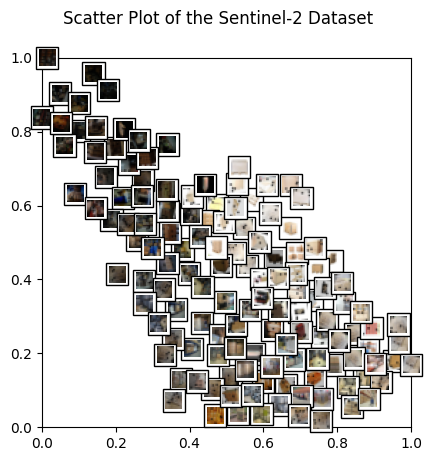

In [12]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays."""
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle("Scatter Plot of the Sentinel-2 Dataset")
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1.0, 1.0]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp["figure.figsize"][0] * 2.0)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1.0 / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable="box")


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

Next, we plot example images and their nearest neighbors (calculated from the embeddings generated above). This is a very simple approach to find more images of a certain type where a few examples are already available. For example, when a subset of the data is already labelled and one class of images is clearly underrepresented, one can easily query more images of this class from the unlabelled dataset.

Let’s get to work! The plots are shown below.

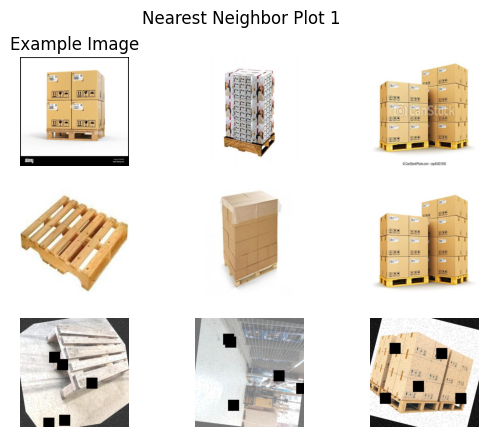

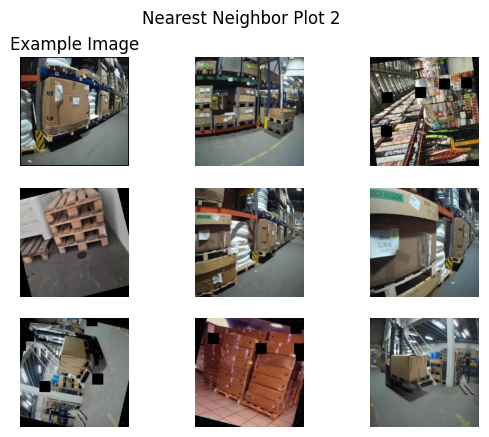

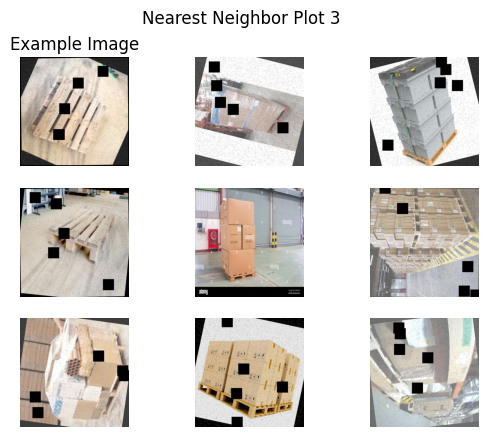

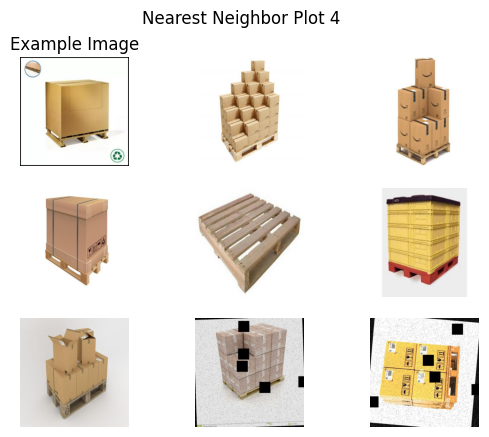

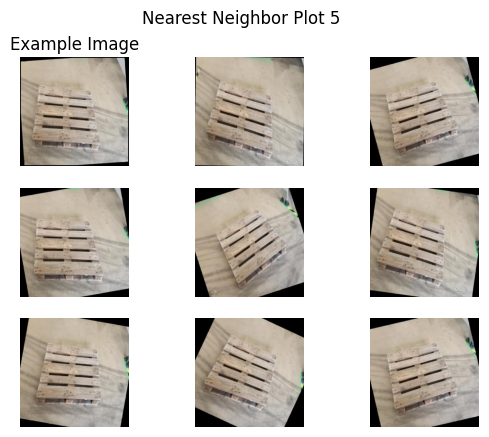

In [14]:
example_images = [
    "00035_jpg.rf.773337cfa5bdb8be4eea2c8ec92d94bd.jpg",
    '00029_jpg.rf.32db29261647ad0b319d23e6840fdff3.jpg',
    '00130_jpg.rf.92ccbbbccb9dbf7cfa1e0ecf2face3c7.jpg',
    '00491_jpg.rf.9f0520798d1837408c6fe69cee3b4170.jpg',
    '00580_jpg.rf.17c64e870d81323dacd340d302362245.jpg'
]


def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array."""
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w."""
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors."""
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)

# Save backbone for future use

In [16]:
# you can always access the backbone model using `.backbone`
# model.backbone

# you can also store the backbone and use it in another code
state_dict = {
    'backbone_mobilenet_v2_parameters': model.backbone.state_dict()
}
torch.save(state_dict, '/workspace/weights/mobilenet_v2-pretrained-ssl-simsiam-pallets.pth')

# Load pretrained backbone

In [17]:
# load the model in a new file for inference

# note that we need to create exactly the same backbone in order to load the weights
mobilenet_v2 = torchvision.models.mobilenet_v2()
backbone_loaded = nn.Sequential(
    *list(mobilenet_v2.children())[:-1],
     nn.AdaptiveAvgPool2d(output_size=(1,1)),
     nn.Flatten(),
     nn.Linear(1280, num_ftrs, bias=False)
    )

ckpt = torch.load('/workspace/weights/mobilenet_v2-pretrained-ssl-simsiam-pallets.pth')
backbone_loaded.load_state_dict(ckpt['backbone_mobilenet_v2_parameters'])

<All keys matched successfully>